## Importing the libraries

In [1]:
#--------------- DATA HANDLING AND MANIPULATION LIBRARIES ---------------#
import random 
import time
import pandas as pd
import numpy as np
import os
import gc
import pickle
from scipy.stats import uniform, truncnorm, randint, mode
from scipy.stats import randint as sp_randint
from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
import datetime
#---------------                 Warning                  ---------------#
import warnings 
warnings.filterwarnings('ignore')

#---------------        Visualization Libraries           ---------------#
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

#---------------        Machine Learning  Libraries       ---------------#
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold
from sklearn.model_selection import train_test_split

In [ ]:
# Update fast ai 
! [ -e /content ] && pip install -Uqq fastai 

In [ ]:
from fastai.torch_basics import *
from fastai.data.all import *

## Mounting Drive

In [2]:
#Mounting drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set up the path

In [3]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


## Helper Functions

### Timer

In [4]:
#refer:-https://www.youtube.com/watch?v=vOMtQ4ocMGI
@contextmanager
def timer(title):
    """ used to calculate time for each function"""
    t0 = time.time()
    yield
    print("{} - done in {:.000f}s".format(title, time.time() - t0))

### Memory Reduction

In [5]:

#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    #loop for alll the columns in the dataframe 
    for col in df.columns:
        #get the datatype of the column
        col_type = df[col].dtypes
        #if the data type is numeric then only start changing the datatype
        #as it isnt much helpful for other data types 
        if col_type in numerics:
            #stores the min value of the column 
            c_min = df[col].min()
            #stores the maximum value of the column
            c_max = df[col].max()
            #for int type numerics
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            #for float type numerics 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Null Values

In [ ]:
def nullValues(df):
  """ Find the columns with null values """
  columns_with_na = [var for var in df.columns if df[var].isnull().mean()  > 0]
  #lets find out the percentage of observations missing per variable

  #calculate the percentage of missing 
  data_na = df[columns_with_na].isnull().mean()

  #transform the array to dataframe 
  data_na = pd.DataFrame(data_na.reset_index())

  #add names to the dataframe 
  data_na.columns = ['col','percentage_na']

  #oreder the dataframe acc to percentage 
  data_na.sort_values(by = 'percentage_na',ascending = False, inplace = True)

  #show
  data_na
  return data_na

# Imputation 

### Problem Summary 
1. There are two main datasets that contain the card id and the target variable loyality score to predict - Train and Test
2. There are two datasets that contain informations about all the transactions buying from different merchants - Historical Transations and New merchants transactions. 
3. There is 1 dataset that contains informations about all the Merchants - Merchant 

### Train and Test
1. From Eda we saw that there is no null value in train or test so no imputation required 


### New Merchants Transactions Data
1. In New Merchant Transactions we saw that there are columns with missing values such as category 3, category 2 and merchant id



In [ ]:
def transactions_preprocessingNEWMERCHANTS(nrows = None):

    """
    FUNCTION:
          PERFORMS THE IMPUTATIONS FOR THE TRANSACTIONS DATA 
          IT HANDLES MISSING VALUES 
          IT DOES MAPPING OF CATEGORICAL DATA TO NUMERICAL 

    ARGS:
           
          NUM_ROWS: TO LOAD THE NUMBER OF ROWS FOR THE DATAFRAME(DEBUGGING)
          DEFAULT IS NONE

    RETURNS:
          THE MODIFIED DATA FRAME WITH IMPUTATIONS 
    """

    def mode(series):
        """Most common element in a series"""
        tmode = series.mode()
        if len(tmode) == 0:
            return np.nan
        else:
            return tmode[0]

    df = pd.read_csv('/content/drive/MyDrive/data/new_merchant_transactions.csv', nrows=nrows)
    

    # fillna
    df.loc[df['category_2'].isna(),'category_2'] = mode(df['category_2'])
    df.loc[df['category_3'].isna(),'category_3'] = mode(df['category_3'])
    #no id of that merchant id is present in the entire dataset so this will be used for missing value 
    df['merchant_id'].fillna('M_ID_0000000000', inplace=True)


    # mapping categorical to numerical 
    # categorical are:- category_1, category_3, authorized_flag
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    df['category_3'] = df['category_3'].map({'A': 0, 'B': 1,'C': 2}).astype(int)

    # reduce memory usage
    df = reduce_mem_usage(df)

    return df

### Historical Transactions data 
1. In Historical Transactions data we saw that there are columns with missing values such as category 3, category 2 and merchant id

In [ ]:
def transactions_preprocessingTRANSACTIONS(nrows = None):

    """
    FUNCTION:
          PERFORMS THE IMPUTATIONS FOR THE TRANSACTIONS DATA 
          IT HANDLES MISSING VALUES 
          IT DOES MAPPING OF CATEGORICAL DATA TO NUMERICAL 

    ARGS:
          
          NUM_ROWS: TO LOAD THE NUMBER OF ROWS FOR THE DATAFRAME(DEBUGGING)
          DEFAULT IS NONE

    RETURNS:
          THE MODIFIED DATA FRAME WITH IMPUTATIONS 
    """

    def mode(series):
        """Most common element in a series"""
        tmode = series.mode()
        if len(tmode) == 0:
            return np.nan
        else:
            return tmode[0]

    df = pd.read_csv('/content/drive/MyDrive/data/historical_transactions.csv', nrows=nrows)

    # fillna
    df.loc[df['category_2'].isna(),'category_2'] = mode(df['category_2'])
    df.loc[df['category_3'].isna(),'category_3'] = mode(df['category_3'])
    #no id of that merchant id is present in the entire dataset so this will be used for missing value
    df['merchant_id'].fillna('M_ID_0000000000', inplace=True)


    # mapping categorical to numerical 
    # categorical are:- category_1, category_3, authorized_flag
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    df['category_3'] = df['category_3'].map({'A': 0, 'B': 1,'C': 2}).astype(int)

    # reduce memory usage
    df = reduce_mem_usage(df)

    return df

### Merchants Data
1. In Merchants data we saw that average_sales_lag3, average_sales_lag6, average_sales_lag12 and category 2 have missing values 

In [ ]:
def merchant_preprocessing(num_rows=None):
    """
    FUNCTION:
          PERFORMS THE IMPUTATIONS FOR THE TRANSACTIONS DATA 
          IT HANDLES MISSING VALUES 
          IT DOES MAPPING OF CATEGORICAL DATA TO NUMERICAL
          IT HANDLES THE INF VALUES  

    ARGS:
          NUM_ROWS: TO LOAD THE NUMBER OF ROWS FOR THE DATAFRAME(DEBUGGING)
          DEFAULT IS NONE
    
    RETURNS:
          THE MODIFIED DATA FRAME WITH IMPUTATIONS 
    """
    def mode(series):
        """Most common element in a series"""
        tmode = series.mode()
        if len(tmode) == 0:
            return np.nan
        else:
            return tmode[0]

    df = pd.read_csv('/content/drive/MyDrive/data/merchants.csv', nrows=num_rows)

    #drop duplicate merchant id
    df.drop_duplicates(subset=['merchant_id'], keep='last')
    #now every cloum represents one merchant 

    #handling categorical 
    df.loc[df['category_2'].isna(),'category_2'] = mode(df['category_2'])

    #imputing the inf values with max 
    # "avg_purchases_lag3","avg_purchases_lag6","avg_purchases_lag12"
    features_inf = ["avg_purchases_lag3","avg_purchases_lag6","avg_purchases_lag12"]
    for col in features_inf:
        df.loc[df[col]==np.inf,col] = max(df.loc[df[col]!=np.inf,col])
    
    # imputing the missing values with model 
    #'avg_sales_lag3','avg_sales_lag6','avg_sales_lag12'
    features_missing = ['avg_sales_lag3','avg_sales_lag6','avg_sales_lag12']
    for col in features_missing:
        df[col].fillna((df[col].mean()), inplace=True)


    #mapping categorical to numerical 
    #categorical is :- category_1,most_recent_sales_range, most_recent_purchases_range, active_months_lag12, category_4
    df['category_1'] = df['category_1'].map({'Y': 0, 'N': 1}).astype(int)
    df['most_recent_sales_range'] = df['most_recent_sales_range'].map({'A': 0, 'B': 1,'C': 2, 'D': 3,'E' : 4}).astype(int)
    df['most_recent_purchases_range'] = df['most_recent_purchases_range'].map({'A': 0, 'B': 1,'C': 2, 'D': 3,'E' : 4}).astype(int)
    df['category_4'] = df['category_4'].map({'Y': 0, 'N': 1, 2 : 2}).astype(int)

    # reduce memory usage
    df = reduce_mem_usage(df)

    return df

In [ ]:
def preprocess(debug, csvConvert = True):
  if debug is True:
    num_rows = 1000
  else:
    num_rows = None
  with timer('new Merchants'):
    new_merchants = transactions_preprocessingNEWMERCHANTS(num_rows)
  with timer('hist trans'):
    hist_transactions = transactions_preprocessingTRANSACTIONS(num_rows)
  with timer('merchants'):
    merchants = merchant_preprocessing(num_rows)

  if csvConvert == True:
    with timer('To CSV '):
      new_merchants.to_csv('newMerchants_trans_preprocessed.csv', index=False)
      hist_transactions.to_csv('hist_trans_preprocessed.csv', index=False)
      merchants.to_csv('merchants_preprocessed.csv', index=False)

  return new_merchants, hist_transactions, merchants

## Imputation Main Function 

In [ ]:
a, b, c = preprocess(False)

Mem. usage decreased to 74.88 Mb (64.3% reduction)
new Merchants - done in 7s
Mem. usage decreased to 1166.08 Mb (62.5% reduction)
hist trans - done in 81s
Mem. usage decreased to 15.64 Mb (72.2% reduction)
merchants - done in 3s
To CSV  - done in 269s


In [ ]:
# See the a dataset 
a

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1,1,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1,1,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,0,1,1,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,1,1,1,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,1.0,-1,8
4,1,C_ID_ef55cf8d4b,-1,1,1,1,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,1.0,-1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963026,1,C_ID_1320dee851,142,0,0,0,309,M_ID_7754b67f3b,2,-0.701660,2018-04-06 14:36:52,3.0,19,21
1963027,1,C_ID_f112aa3381,158,0,0,0,560,M_ID_da063195b7,2,-0.694336,2018-03-07 13:19:18,1.0,15,34
1963028,1,C_ID_bd97b86450,69,0,1,1,278,M_ID_9a9ccb6544,1,-0.621094,2018-03-05 12:04:56,1.0,9,37
1963029,1,C_ID_c0513fd84f,130,0,0,0,367,M_ID_40c28d596f,1,-0.656738,2018-03-09 14:47:05,3.0,7,16


In [ ]:
# check for null values 
a.isna().sum()

authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

In [ ]:
# See the b dataset 
b

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29112356,1,C_ID_2863d2fa95,-1,1,1,1,360,M_ID_edd92b6720,-1,-0.632706,2017-01-20 08:52:04,1.0,-1,34
29112357,1,C_ID_2863d2fa95,-1,1,1,1,360,M_ID_edd92b6720,0,-0.632706,2017-02-20 04:40:50,1.0,-1,34
29112358,1,C_ID_5c240d6e3c,3,0,0,0,278,M_ID_9cdcfe8673,0,-0.657740,2017-12-26 18:37:51,1.0,16,37
29112359,1,C_ID_5c240d6e3c,331,0,0,0,514,M_ID_1a75f94f92,-1,0.770620,2017-11-24 14:18:15,1.0,16,9


In [ ]:
# check for null values 
b.isna().sum()

authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

In [ ]:
# see the c dataset 
c

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,1,4,4,-0.400000,9.664062,3,-2.250000,18.671875,6,-2.320000,13.914062,12,1,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,1,4,4,-0.720000,1.750000,3,-0.740000,1.291992,6,-0.570000,1.687500,12,1,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,1,4,4,-82.129997,260.000000,2,-82.129997,260.000000,2,-82.129997,260.000000,2,1,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,0,4,4,13.832993,1.666992,3,21.650787,4.667969,6,25.227709,3.833984,12,0,-1,-1,1.0
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,0,4,4,13.832993,0.500000,3,21.650787,0.361084,6,25.227709,0.347168,12,0,-1,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334691,M_ID_1f4773aa76,1145,705,33,3.173828,-0.047546,1,0,0,1.000000,1.022461,3,0.990000,1.019531,6,1.000000,1.024414,12,0,69,9,1.0
334692,M_ID_725a60d404,35,544,29,-0.057465,-0.057465,0,0,0,0.890000,0.927734,3,0.780000,0.813477,6,0.590000,0.606934,12,0,-1,-1,1.0
334693,M_ID_f2045dd267,35,561,7,-0.057465,-0.057465,1,0,0,0.960000,0.982910,3,0.900000,0.924805,6,0.740000,0.750977,8,0,160,21,5.0
334694,M_ID_9139332ccc,35,511,7,-0.057465,-0.057465,0,0,0,0.940000,0.919434,3,0.820000,0.783203,6,0.650000,0.583984,12,0,-1,-1,1.0


In [ ]:
# check for null values 
c.isna().sum()

merchant_id                    0
merchant_group_id              0
merchant_category_id           0
subsector_id                   0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
city_id                        0
state_id                       0
category_2                     0
dtype: int64

In [ ]:
del a,b,c
gc.collect()

495

# Feature Engineering 

## Date Part

In [ ]:
def add_datepart(df, fldname, drop=True, time=False):
    """
    Helper function that adds columns relevant to a date.
    -----------------------------------------------------
    Args:
          df: The data frame on which you want to perform operations 
          fldname: The name of the column
          drop: Drop the parent column from the data frame 
          time: Add attributes such as hour, minute and second
    ------------------------------------------------------
    This code is taken from the below link 
    Refer:-https://gist.github.com/adidoit/d32f6117647b0e8564edc6507f9e3625
    Refer:-https://colab.research.google.com/github/fastai/fastai/blob/master/nbs/40_tabular.core.ipynb#scrollTo=qt7-T33VVNwx
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    #https://www.programiz.com/python-programming/methods/built-in/getattr
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

## Date Time feature 

In [ ]:
def dateTimeFeatures(df):
  """

    To retuurn a dataframe with new date time features 
    ---------------------------------------------------------
    Args:
      df:- The dataframe on which we want to do 
    ---------------------------------------------------------
    Returns:
    A dataframe with date time features 
    ---------------------------------------------------------
    To DO:
      1. Add holidays 

  """

  # basic date time features
  df['purchasedWeekend'] = (df.purchase_Dayofweek >=5).astype(int)
  df['purchasedWeekday'] = (df.purchase_Dayofweek <5).astype(int)
  #difference in months from today
  df['monthDiff'] = ((datetime.today() - df['purchase_date']).dt.days) // 30
  #month lag to reference date
  df['monthDiff'] += df['month_lag']

  return df

### Read The files

In [ ]:
#read the files 
with timer('Read Files'):
  histDf = reduce_mem_usage(pd.read_csv("hist_trans_preprocessed.csv",parse_dates=['purchase_date']))
  newdf = reduce_mem_usage(pd.read_csv("newMerchants_trans_preprocessed.csv",parse_dates=['purchase_date']) )

Mem. usage decreased to 1166.08 Mb (62.5% reduction)
Mem. usage decreased to 74.88 Mb (64.3% reduction)
Read Files - done in 87s


### Append the files 

In [ ]:
transactions = histDf.append(newdf, ignore_index=True)

In [ ]:
# delete the dataframes 
del histDf, newdf
gc.collect()

11

### Extract the date time features

In [ ]:
# Add date time features to transactions dataframe 
with timer("Date time features and mapping"):
  add_datepart(transactions, 'purchase_date', drop=False, time=True)
  transactions = dateTimeFeatures(transactions)
  mapping = {False:0, True:1}
  transactions.replace({"purchase_Is_month_end": mapping,
                      "purchase_Is_month_start": mapping,
                      "purchase_Is_quarter_end": mapping,
                      "purchase_Is_quarter_start": mapping,
                      "purchase_Is_year_end": mapping,
                      "purchase_Is_year_start": mapping},
                     inplace = True)

Date time features and mapping - done in 66s


In [ ]:
# View the dataframe 
transactions.head().T

,0,1,2,3,4
authorized_flag,1,1,1,1,1
card_id,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc
city_id,88,88,88,88,88
category_1,0,0,0,0,0
installments,0,0,0,0,0
category_3,0,0,0,0,0
merchant_category_id,80,367,80,560,80
merchant_id,M_ID_e020e9b302,M_ID_86ec983688,M_ID_979ed661fc,M_ID_e6d5ae8ea6,M_ID_e020e9b302
month_lag,-8,-7,-6,-5,-11
purchase_amount,-0.703331,-0.733128,-0.720386,-0.735352,-0.722865


### Purchase Amount featurization 

In [ ]:
#Refer:-https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights
transactions['purchase_amount'] = np.round(transactions['purchase_amount'] / 0.00150265118 + 497.06,2)

In [ ]:
transactions.purchase_amount

0           29.00
1            9.17
2           17.65
3            7.69
4           16.00
            ...  
31075387    30.11
31075388    34.99
31075389    83.73
31075390    60.01
31075391     5.09
Name: purchase_amount, Length: 31075392, dtype: float64

In [ ]:
#find the percentile value to get the outliners 
for i in range(90, 101):
  print("{} percentile value is {:3.3f}".format(i, np.percentile(transactions['purchase_amount'], i)))

90 percentile value is 215.000
91 percentile value is 236.310
92 percentile value is 260.000
93 percentile value is 294.900
94 percentile value is 331.830
95 percentile value is 389.200
96 percentile value is 467.650
97 percentile value is 590.000
98 percentile value is 800.070
99 percentile value is 1322.000
100 percentile value is 4000000017.910


In [ ]:
# Remove the 100th percentile 
transactions.drop(transactions[transactions['purchase_amount'] ==   4000000017.910].index, inplace=True)

In [ ]:
# one hot encoding 
transactions = pd.get_dummies(transactions, columns=['purchasedWeekday', 'purchase_Month', 'purchasedWeekend', 'purchase_Dayofweek'])
transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_Year,purchase_Week,purchase_Day,purchase_Dayofyear,purchase_Is_month_end,purchase_Is_month_start,purchase_Is_quarter_end,purchase_Is_quarter_start,purchase_Is_year_end,purchase_Is_year_start,purchase_Hour,purchase_Minute,purchase_Second,purchase_Elapsed,monthDiff,purchasedWeekday_0,purchasedWeekday_1,purchase_Month_1,purchase_Month_2,purchase_Month_3,purchase_Month_4,purchase_Month_5,purchase_Month_6,purchase_Month_7,purchase_Month_8,purchase_Month_9,purchase_Month_10,purchase_Month_11,purchase_Month_12,purchasedWeekend_0,purchasedWeekend_1,purchase_Dayofweek_0,purchase_Dayofweek_1,purchase_Dayofweek_2,purchase_Dayofweek_3,purchase_Dayofweek_4,purchase_Dayofweek_5,purchase_Dayofweek_6
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,29.00,2017-06-25 15:33:07,1.0,16,37,2017,25,25,176,0,0,0,0,0,0,15,33,7,1498404787,36,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,9.17,2017-07-15 12:10:45,1.0,16,16,2017,28,15,196,0,0,0,0,0,0,12,10,45,1500120645,36,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_979ed661fc,-6,17.65,2017-08-09 22:04:29,1.0,16,37,2017,32,9,221,0,0,0,0,0,0,22,4,29,1502316269,37,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
3,1,C_ID_4e6213e9bc,88,0,0,0,560,M_ID_e6d5ae8ea6,-5,7.69,2017-09-02 10:06:26,1.0,16,34,2017,35,2,245,0,0,0,0,0,0,10,6,26,1504346786,37,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
4,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-11,16.00,2017-03-10 01:14:19,1.0,16,37,2017,10,10,69,0,0,0,0,0,0,1,14,19,1489108459,37,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


## Date Time Aggregations 

In [ ]:
def mode(series):
    """Most common element in a series"""
    tmode = series.value_counts().idxmax()
    return tmode
        
def period(series):
    """Period of a series (max-min)"""
    return series.max() - series.min()

def mean_diff(series):
    """Mean difference between consecutive items in a series"""
    ss = series.sort_values()
    return (ss - ss.shift()).mean()


common_aggs = ['sum', 'mean', 'std']

In [ ]:
aggs = {
      'purchase_Year' : mode,
      'purchase_Week' : common_aggs,
      'purchase_Day' : [period , mean_diff, 'min', 'max'],
      'purchase_Dayofyear' : common_aggs, 
      'purchase_Is_month_end' : common_aggs,
      'purchase_Is_month_start' : common_aggs, 
      'purchase_Is_quarter_end' : common_aggs,
      'purchase_Is_quarter_start' : common_aggs, 
      'purchase_Is_year_end' : common_aggs,
      'purchase_Is_year_start' :common_aggs, 
      'purchase_Hour' : common_aggs, 
      'purchase_Minute' : common_aggs,
      'purchase_Second' : common_aggs, 
      'purchase_Elapsed' : common_aggs, 
      'purchasedWeekday_0' : common_aggs, 
      'purchasedWeekday_1': common_aggs, 
      'purchase_Month_1': common_aggs,
      'purchase_Month_2': common_aggs, 
      'purchase_Month_3': common_aggs, 
      'purchase_Month_4': common_aggs,
      'purchase_Month_5': common_aggs, 
      'purchase_Month_6': common_aggs, 
      'purchase_Month_7': common_aggs,
      'purchase_Month_8': common_aggs, 
      'purchase_Month_9': common_aggs, 
      'purchase_Month_10': common_aggs,
      'purchase_Month_11': common_aggs, 
      'purchase_Month_12': common_aggs, 
      'purchasedWeekend_0': common_aggs,
      'purchasedWeekend_1': common_aggs, 
      'purchase_Dayofweek_0': common_aggs, 
      'purchase_Dayofweek_1': common_aggs,
      'purchase_Dayofweek_2': common_aggs, 
      'purchase_Dayofweek_3': common_aggs, 
      'purchase_Dayofweek_4': common_aggs,
      'purchase_Dayofweek_5': common_aggs, 
      'purchase_Dayofweek_6': common_aggs,
      'monthDiff' : [period , mean_diff, 'min', 'max']
}

In [ ]:
with timer("Agg function"):
  dateTimeFeatures = transactions.groupby('card_id').agg(aggs)
  #rename 
  dateTimeFeatures.columns = ['_'.join(col).strip() 
                            for col in dateTimeFeatures.columns.values]

Agg function - done in 857s


In [ ]:
dateTimeFeatures.head()

,purchase_Year_mode,purchase_Week_sum,purchase_Week_mean,purchase_Week_std,purchase_Day_period,purchase_Day_mean_diff,purchase_Day_min,purchase_Day_max,purchase_Dayofyear_sum,purchase_Dayofyear_mean,purchase_Dayofyear_std,purchase_Is_month_end_sum,purchase_Is_month_end_mean,purchase_Is_month_end_std,purchase_Is_month_start_sum,purchase_Is_month_start_mean,purchase_Is_month_start_std,purchase_Is_quarter_end_sum,purchase_Is_quarter_end_mean,purchase_Is_quarter_end_std,purchase_Is_quarter_start_sum,purchase_Is_quarter_start_mean,purchase_Is_quarter_start_std,purchase_Is_year_end_sum,purchase_Is_year_end_mean,purchase_Is_year_end_std,purchase_Is_year_start_sum,purchase_Is_year_start_mean,purchase_Is_year_start_std,purchase_Hour_sum,purchase_Hour_mean,purchase_Hour_std,purchase_Minute_sum,purchase_Minute_mean,purchase_Minute_std,purchase_Second_sum,purchase_Second_mean,purchase_Second_std,purchase_Elapsed_sum,purchase_Elapsed_mean,...,purchase_Month_10_sum,purchase_Month_10_mean,purchase_Month_10_std,purchase_Month_11_sum,purchase_Month_11_mean,purchase_Month_11_std,purchase_Month_12_sum,purchase_Month_12_mean,purchase_Month_12_std,purchasedWeekend_0_sum,purchasedWeekend_0_mean,purchasedWeekend_0_std,purchasedWeekend_1_sum,purchasedWeekend_1_mean,purchasedWeekend_1_std,purchase_Dayofweek_0_sum,purchase_Dayofweek_0_mean,purchase_Dayofweek_0_std,purchase_Dayofweek_1_sum,purchase_Dayofweek_1_mean,purchase_Dayofweek_1_std,purchase_Dayofweek_2_sum,purchase_Dayofweek_2_mean,purchase_Dayofweek_2_std,purchase_Dayofweek_3_sum,purchase_Dayofweek_3_mean,purchase_Dayofweek_3_std,purchase_Dayofweek_4_sum,purchase_Dayofweek_4_mean,purchase_Dayofweek_4_std,purchase_Dayofweek_5_sum,purchase_Dayofweek_5_mean,purchase_Dayofweek_5_std,purchase_Dayofweek_6_sum,purchase_Dayofweek_6_mean,purchase_Dayofweek_6_std,monthDiff_period,monthDiff_mean_diff,monthDiff_min,monthDiff_max
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,2017,3836,25.403974,14.296936,30,0.200000,1,31,26408,174.887417,100.681646,3,0.019868,0.140009,10,0.066225,0.249503,0,0.000000,0.000000,2,0.013245,0.114703,0,0.000000,0.000000,1,0.006623,0.081379,2175,14.403974,4.209796,4552,30.145695,17.559953,4384,29.033113,17.460973,227001125104,1.503319e+09,...,17.0,0.112583,0.317134,6.0,0.039735,0.195986,12.0,0.079470,0.271371,126.0,0.834437,0.372925,25.0,0.165563,0.372925,43.0,0.284768,0.452806,17.0,0.112583,0.317134,25.0,0.165563,0.372925,25.0,0.165563,0.372925,16.0,0.105960,0.308811,21.0,0.139073,0.347174,4.0,0.026490,0.161122,1,0.006667,36,37
C_ID_0001238066,2018,4020,26.979866,20.460730,29,0.195946,1,30,27855,186.946309,143.940152,1,0.006711,0.081923,3,0.020134,0.140933,0,0.000000,0.000000,1,0.006711,0.081923,0,0.000000,0.000000,0,0.000000,0.000000,2208,14.818792,5.862217,4269,28.651007,16.055615,4270,28.657718,19.364139,225799834810,1.515435e+09,...,11.0,0.073826,0.262369,23.0,0.154362,0.362514,37.0,0.248322,0.433497,85.0,0.570470,0.496679,64.0,0.429530,0.496679,11.0,0.073826,0.262369,20.0,0.134228,0.342047,12.0,0.080537,0.273040,19.0,0.127517,0.334676,23.0,0.154362,0.362514,41.0,0.275168,0.448105,23.0,0.154362,0.362514,1,0.006757,36,37
C_ID_0001506ef0,2017,1811,26.632353,19.511883,30,0.447761,1,31,12565,184.779412,136.566079,1,0.014706,0.121268,1,0.014706,0.121268,1,0.014706,0.121268,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,863,12.691176,3.342433,1993,29.308824,17.999384,2066,30.382353,17.540596,102415567646,1.506111e+09,...,3.0,0.044118,0.206883,7.0,0.102941,0.306141,18.0,0.264706,0.444457,36.0,0.529412,0.502845,32.0,0.470588,0.502845,4.0,0.058824,0.237044,9.0,0.132353,0.341394,6.0,0.088235,0.285746,10.0,0.147059,0.356798,7.0,0.102941,0.306141,28.0,0.411765,0.495812,4.0,0.058824,0.237044,1,0.014925,36,37
C_ID_0001793786,2017,7361,29.801619,11.855375,30,0.121951,1,31,50985,206.417004,83.052292,7,0.028340,0.166279,6,0.024291,0.154265,4,0.016194,0.126479,1,0.004049,0.063628,4,0.016194,0.126479,0,0.000000,0.000000,372

In [ ]:
def remove_noninformative(df):
    """Remove non-informative columns (all nan, or all same value)"""
    for col in df:
        if df[col].isnull().all():
            print('Removing '+col+' (all NaN)')
            del df[col]
        elif df[col].nunique()<2:
            print('Removing '+col+' (only 1 unique value)')
            del df[col]

remove_noninformative(dateTimeFeatures)
gc.collect()

0

In [ ]:
# Save those features
dateTimeFeatures.to_csv('dateTimeFeatures.csv')

In [ ]:
del dateTimeFeatures
gc.collect()

449

# Feature Engineering on other features 

In [ ]:
common_aggs = ['sum', 'mean', 'std']
common_aggs1 = ['sum', 'mean', 'min', 'max', 'std']
aggs = {
      'authorized_flag' : common_aggs,
      'category_1' : common_aggs,
      'category_2' : common_aggs,
      'category_3' : common_aggs, 
      'month_lag' : common_aggs1, 
      'installments' : common_aggs1,
      'purchase_amount' : common_aggs1
}

In [ ]:
with timer("Other Features"):
  otherFeatures = transactions.groupby('card_id').agg(aggs)
  #rename 
  otherFeatures.columns = ['_'.join(col).strip() 
                            for col in otherFeatures.columns.values]

Other Features - done in 18s


In [ ]:
otherFeatures.head()

,authorized_flag_sum,authorized_flag_mean,authorized_flag_std,category_1_sum,category_1_mean,category_1_std,category_2_sum,category_2_mean,category_2_std,category_3_sum,category_3_mean,category_3_std,month_lag_sum,month_lag_mean,month_lag_min,month_lag_max,month_lag_std,installments_sum,installments_mean,installments_min,installments_max,installments_std,purchase_amount_sum,purchase_amount_mean,purchase_amount_min,purchase_amount_max,purchase_amount_std
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,116.0,0.768212,0.423379,28.0,0.185430,0.389940,397.0,2.628906,0.813354,175.0,1.158940,0.366837,-868.0,-5.748344,-12,2,3.546301,194,1.284768,1,6,0.760504,23032.24,152.531391,12.00,1500.00,197.409986
C_ID_0001238066,146.0,0.979866,0.140933,4.0,0.026846,0.162177,241.0,1.617188,1.450057,181.0,1.214765,0.473112,-188.0,-1.261745,-5,2,1.690178,240,1.610738,-1,10,1.596920,15966.41,107.157114,4.12,1008.22,124.426646
C_ID_0001506ef0,64.0,0.941176,0.237044,0.0,0.000000,0.000000,200.0,2.941406,0.340428,1.0,0.014706,0.121268,-317.0,-4.661765,-13,1,4.290254,1,0.014706,0,1,0.121268,9809.72,144.260588,4.27,1491.00,310.398216
C_ID_0001793786,220.0,0.890688,0.312664,2.0,0.008097,0.089801,375.0,1.518555,0.679754,5.0,0.020243,0.141116,-678.0,-2.744939,-9,2,2.657197,5,0.020243,0,1,0.141116,98140.69,397.330729,1.00,3527.80,565.961144
C_ID_000183fdda,148.0,0.954839,0.208331,4.0,0.025806,0.159071,444.0,2.865234,0.547455,191.0,1.232258,0.494376,-339.0,-2.187097,-6,2,2.066389,280,1.806452,-1,10,2.070500,26847.17,173.207548,6.00,2337.00,338.702256


In [ ]:
# save in csv
otherFeatures.to_csv('otherFeatures.csv')

In [ ]:
del otherFeatures
gc.collect()

449

# Merchants Feature engineering 

In [ ]:
merchants = pd.read_csv("merchants_preprocessed.csv") 
merchants.columns = 'mer_' + merchants.columns.values
merchants.rename(columns = {'mer_merchant_id':'merchant_id'}, inplace = True) 

In [ ]:
requiredTrans = transactions[['card_id', 'merchant_id']]

In [ ]:
# merge 
merTrans = pd.merge(requiredTrans, merchants, on='merchant_id', how='left')

In [ ]:
# delete the unnecessary files 
del requiredTrans, merchants
gc.collect()

18

In [ ]:
merTrans.head().T

,0,1,2,3,4
card_id,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc
merchant_id,M_ID_e020e9b302,M_ID_86ec983688,M_ID_979ed661fc,M_ID_e6d5ae8ea6,M_ID_e020e9b302
mer_merchant_group_id,35,2084,27369,24104,35
mer_merchant_category_id,80,367,80,560,80
mer_subsector_id,37,16,37,34,37
mer_numerical_1,23.47,1.093,0.02185,-0.05746,23.47
mer_numerical_2,23.02,-0.05746,0.02185,-0.05746,23.02
mer_category_1,1,1,1,1,1
mer_most_recent_sales_range,0,0,2,3,0
mer_most_recent_purchases_range,0,0,2,2,0


In [ ]:
common_aggs = ['sum', 'mean', 'std']
common_aggs1 = ['sum', 'mean', 'min', 'max', 'std']
aggs = {
      #Numerical features 
      'mer_numerical_1' : common_aggs1,
      'mer_numerical_2' : common_aggs1,
      'mer_avg_sales_lag3' : common_aggs1,
      'mer_avg_sales_lag6' : common_aggs, 
      'mer_avg_sales_lag12' : common_aggs1, 
      'mer_avg_purchases_lag3' : common_aggs1,
      'mer_avg_purchases_lag6' : common_aggs1,
      'mer_avg_purchases_lag12' : common_aggs1,
      'mer_active_months_lag3' : common_aggs1,
      'mer_active_months_lag6' : common_aggs1,
      'mer_active_months_lag12' : common_aggs1, 

      #categorical features 
      'mer_category_1' : common_aggs, 
      'mer_most_recent_sales_range' : common_aggs,
      'mer_most_recent_purchases_range' : common_aggs,
      'mer_category_4' : common_aggs,
      'mer_category_2' : common_aggs
}

In [ ]:
with timer("Merchant Features"):
  merfeat = merTrans.groupby('card_id').agg(aggs)
  #rename 
  merfeat.columns = ['_'.join(col).strip() 
                           for col in merfeat.columns.values]
  # store the features in a csv file 
  merfeat.to_csv('merfeat.csv')

Merchant Features - done in 82s


In [ ]:
# Show the dataframe 
merfeat.head().T

card_id,C_ID_00007093c1,C_ID_0001238066,C_ID_0001506ef0,C_ID_0001793786,C_ID_000183fdda
mer_numerical_1_sum,269.939310,1323.800540,65.512400,287.191826,32.500636
mer_numerical_1_mean,1.775917,8.884567,0.949455,1.135146,0.203129
mer_numerical_1_min,-0.057460,-0.057460,-0.057460,-0.057460,-0.057460
mer_numerical_1_max,15.860000,129.400000,15.390000,117.800000,4.523000
mer_numerical_1_std,4.376179,30.209769,2.570104,8.175037,0.733163
...,...,...,...,...,...
mer_category_4_mean,0.657895,0.798658,0.014493,0.292490,0.043750
mer_category_4_std,0.475983,0.402356,0.120386,0.455808,0.205181
mer_category_2_sum,396.000000,233.000000,199.000000,467.000000,440.000000
mer_category_2_mean,2.605263,1.563758,2.884058,1.845850,2.750000


# Merge Everything 

In [ ]:
#read all the features 
dateTimeFeatures = reduce_mem_usage(pd.read_csv("dateTimeFeatures.csv"))
otherFeatures = reduce_mem_usage(pd.read_csv("otherFeatures.csv"))

Mem. usage decreased to 76.99 Mb (73.0% reduction)
Mem. usage decreased to 20.80 Mb (70.1% reduction)


In [ ]:
#load train and test 
train = reduce_mem_usage(pd.read_csv("train.csv"))
test = reduce_mem_usage(pd.read_csv("test.csv"))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


## Feature Engneering for main data 

In [ ]:
def featureEngineering(df):
  #some feature engineering based on the main train set features 
  df['first_active_month'] = pd.to_datetime(df['first_active_month'])

  # datetime features
  df['year'] =  df['first_active_month'].dt.year
  df['quarter'] = df['first_active_month'].dt.quarter
  df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

  # Some basic statistics transformations over the feature_i columns
  df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
  df['feature_mean'] = df['feature_sum'] / 3
  df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
  df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
  df['feature_std'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)

  return df 

In [ ]:
train = featureEngineering(train)
test = featureEngineering(test)

In [ ]:
#now merge the features on the basis of card id 

#date time features 
train = pd.merge(train, dateTimeFeatures,on='card_id', how='left' )
test = pd.merge(test, dateTimeFeatures,on='card_id', how='left' )

In [ ]:
#otherFeatures
train = pd.merge(train, otherFeatures,on='card_id', how='left' )
test = pd.merge(test, otherFeatures,on='card_id', how='left' )

In [ ]:
#merchant features 
train = pd.merge(train, merfeat,on='card_id', how='left' )
test = pd.merge(test, merfeat,on='card_id', how='left' )

In [ ]:
def remove_noninformative(df):
    """Remove non-informative columns (all nan, or all same value)"""
    for col in df:
        if df[col].isnull().all():
            print('Removing '+col+' (all NaN)')
            del df[col]
        elif df[col].nunique()<2:
            print('Removing '+col+' (only 1 unique value)')
            del df[col]

remove_noninformative(train)
gc.collect()

Removing mer_active_months_lag3_max (only 1 unique value)
Removing mer_active_months_lag6_max (only 1 unique value)


5

In [ ]:
col = ['mer_active_months_lag3_max','mer_active_months_lag6_max']
test.drop(col, axis=1,inplace = True )

In [ ]:
train.to_csv('FINAL_TRAIN_M.csv')
test.to_csv('FINAL_TEST_M.csv')

In [ ]:
train

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,quarter,elapsed_time,feature_sum,feature_mean,feature_max,feature_min,feature_std,purchase_Year_mode,purchase_Week_sum,purchase_Week_mean,purchase_Week_std,purchase_Day_period,purchase_Day_mean_diff,purchase_Day_min,purchase_Day_max,purchase_Dayofyear_sum,purchase_Dayofyear_mean,purchase_Dayofyear_std,purchase_Is_month_end_sum,purchase_Is_month_end_mean,purchase_Is_month_end_std,purchase_Is_month_start_sum,purchase_Is_month_start_mean,purchase_Is_month_start_std,purchase_Is_quarter_end_sum,purchase_Is_quarter_end_mean,purchase_Is_quarter_end_std,purchase_Is_quarter_start_sum,purchase_Is_quarter_start_mean,purchase_Is_quarter_start_std,purchase_Is_year_end_sum,purchase_Is_year_end_mean,purchase_Is_year_end_std,...,mer_avg_purchases_lag3_max,mer_avg_purchases_lag3_std,mer_avg_purchases_lag6_sum,mer_avg_purchases_lag6_mean,mer_avg_purchases_lag6_min,mer_avg_purchases_lag6_max,mer_avg_purchases_lag6_std,mer_avg_purchases_lag12_sum,mer_avg_purchases_lag12_mean,mer_avg_purchases_lag12_min,mer_avg_purchases_lag12_max,mer_avg_purchases_lag12_std,mer_active_months_lag3_sum,mer_active_months_lag3_mean,mer_active_months_lag3_min,mer_active_months_lag3_std,mer_active_months_lag6_sum,mer_active_months_lag6_mean,mer_active_months_lag6_min,mer_active_months_lag6_std,mer_active_months_lag12_sum,mer_active_months_lag12_mean,mer_active_months_lag12_min,mer_active_months_lag12_max,mer_active_months_lag12_std,mer_category_1_sum,mer_category_1_mean,mer_category_1_std,mer_most_recent_sales_range_sum,mer_most_recent_sales_range_mean,mer_most_recent_sales_range_std,mer_most_recent_purchases_range_sum,mer_most_recent_purchases_range_mean,mer_most_recent_purchases_range_std,mer_category_4_sum,mer_category_4_mean,mer_category_4_std,mer_category_2_sum,mer_category_2_mean,mer_category_2_std
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,2017,2,1363,8,2.666667,5,1,2.081666,2017,8905,31.468750,15.554688,30,0.106384,1,31,61760,218.250,109.1875,9,0.031799,0.175781,7,0.024734,0.155640,5,0.017670,0.131958,3,0.010597,0.102600,1,0.003534,0.059448,...,12.700,2.100472,5482.1956,19.440410,0.3210,504.200,93.291987,6044.1276,21.433077,0.2530,554.50,102.781945,846.0,3.000000,3.0,0.000000,1691.0,5.996454,5.0,0.059549,3348.0,11.872340,5.0,12.0,0.794564,258.0,0.914894,0.279536,469.0,1.663121,1.278061,410.0,1.453901,1.287637,16.0,0.056738,0.231752,294.0,1.042553,0.411098
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,2017,1,1514,5,1.666667,4,0,2.081666,2017,8881,24.953125,16.703125,30,0.084534,1,31,61516,172.750,117.1875,12,0.033722,0.180786,15,0.042145,0.201172,6,0.016861,0.128906,6,0.016861,0.128906,3,0.008430,0.091553,...,12.700,1.900253,1546.0590,4.167275,0.3079,504.200,36.935609,1679.2061,4.526162,0.2090,554.50,40.632768,1113.0,3.000000,3.0,0.000000,2226.0,6.000000,6.0,0.000000,4401.0,11.862534,7.0,12.0,0.788411,309.0,0.832884,0.373583,403.0,1.086253,1.362867,397.0,1.070081,1.363796,29.0,0.078167,0.268797,371.0,1.000000,0.000000
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988,2016,3,1667,4,1.333333,2,0,1.154701,2017,807,18.343750,13.726562,28,0.651367,2,30,5572,126.625,96.5000,1,0.022720,0.150757,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,12.700,1.740745,61.9623,1.376940,0.8710,15.860,2.209385,62.8402,1.396449,0.7524,16.22,2.262011,135.0,3.000000,3.0,0.000000,270.0,6.000000,6.0,0.000000,533.0,11.844444,7.0,12.0,0.796457,43.0,0.955556,0.208409,18.0,0.400000,0.962950,18.0,0.400000,1.009050,3.0,0.066667,0.252262,205.0,4.555556,1.271283
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456,2017,3,1271,7,2.333333,4,0,2.081666,2017,2562,30.500000,17.140625,29,0.349365,2,31,17723,211.000,120.3750,3,0.035706,0.186646,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,12.700,3.421336,230.8617,2.404809,0.4263,15.860,4.353754,234.0799,2.438332,0.4360,16.22,4.461906,288.0,3.000000,3.0,0.000000,576.0,6.000000,6.0,0.000000,1094.0,11.395833,7.0,12.0,1.538825,6

In [ ]:
test

,first_active_month,card_id,feature_1,feature_2,feature_3,year,quarter,elapsed_time,feature_sum,feature_mean,feature_max,feature_min,feature_std,purchase_Year_mode,purchase_Week_sum,purchase_Week_mean,purchase_Week_std,purchase_Day_period,purchase_Day_mean_diff,purchase_Day_min,purchase_Day_max,purchase_Dayofyear_sum,purchase_Dayofyear_mean,purchase_Dayofyear_std,purchase_Is_month_end_sum,purchase_Is_month_end_mean,purchase_Is_month_end_std,purchase_Is_month_start_sum,purchase_Is_month_start_mean,purchase_Is_month_start_std,purchase_Is_quarter_end_sum,purchase_Is_quarter_end_mean,purchase_Is_quarter_end_std,purchase_Is_quarter_start_sum,purchase_Is_quarter_start_mean,purchase_Is_quarter_start_std,purchase_Is_year_end_sum,purchase_Is_year_end_mean,purchase_Is_year_end_std,purchase_Is_year_start_sum,...,mer_avg_purchases_lag3_max,mer_avg_purchases_lag3_std,mer_avg_purchases_lag6_sum,mer_avg_purchases_lag6_mean,mer_avg_purchases_lag6_min,mer_avg_purchases_lag6_max,mer_avg_purchases_lag6_std,mer_avg_purchases_lag12_sum,mer_avg_purchases_lag12_mean,mer_avg_purchases_lag12_min,mer_avg_purchases_lag12_max,mer_avg_purchases_lag12_std,mer_active_months_lag3_sum,mer_active_months_lag3_mean,mer_active_months_lag3_min,mer_active_months_lag3_std,mer_active_months_lag6_sum,mer_active_months_lag6_mean,mer_active_months_lag6_min,mer_active_months_lag6_std,mer_active_months_lag12_sum,mer_active_months_lag12_mean,mer_active_months_lag12_min,mer_active_months_lag12_max,mer_active_months_lag12_std,mer_category_1_sum,mer_category_1_mean,mer_category_1_std,mer_most_recent_sales_range_sum,mer_most_recent_sales_range_mean,mer_most_recent_sales_range_std,mer_most_recent_purchases_range_sum,mer_most_recent_purchases_range_mean,mer_most_recent_purchases_range_std,mer_category_4_sum,mer_category_4_mean,mer_category_4_std,mer_category_2_sum,mer_category_2_mean,mer_category_2_std
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,2017.0,2.0,1424.0,7,2.333333,3,1,1.154701,2017,2370,33.375000,11.820312,30,0.428467,1,31,16433,231.5000,82.93750,5,0.070435,0.257568,3,0.042267,0.202637,2,0.028168,0.166626,0,0.000000,0.000000,0,0.0,0.0,0,...,12.7000,2.359456,123.7316,1.672049,0.7830,15.860,3.018188,119.3758,1.613186,0.5840,16.220,3.100155,222.0,3.0,3.0,0.0,444.0,6.000000,6.0,0.000000,873.0,11.797297,7.0,12.0,0.992847,45.0,0.608108,0.491505,124.0,1.675676,1.405548,125.0,1.689189,1.461147,39.0,0.527027,0.502677,74.0,1.000000,0.000000
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,2017.0,1.0,1514.0,5,1.666667,3,0,1.527525,2017,1082,12.437500,5.433594,28,0.325684,2,30,7384,84.8750,37.96875,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,...,12.7000,1.246947,106.3753,1.208810,0.8600,15.860,1.582889,109.2195,1.241131,0.7104,16.220,1.655722,264.0,3.0,3.0,0.0,528.0,6.000000,6.0,0.000000,1047.0,11.897727,7.0,12.0,0.678737,83.0,0.943182,0.232822,155.0,1.761364,1.093285,151.0,1.715909,1.092807,82.0,0.931818,0.253502,337.0,3.829545,0.698465
2,2017-08-01,C_ID_b709037bc5,5,1,1,2017.0,3.0,1302.0,7,2.333333,5,1,2.309401,2017,397,26.468750,20.687500,24,1.713867,1,25,2735,182.3750,144.62500,0,0.000000,0.000000,1,0.066650,0.258301,0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,...,1.2705,0.138129,16.5092,1.100613,0.6323,1.475,0.228810,16.5713,1.104753,0.5840,1.452,0.266685,45.0,3.0,3.0,0.0,90.0,6.000000,6.0,0.000000,180.0,12.000000,12.0,12.0,0.000000,13.0,0.866667,0.351866,26.0,1.733333,0.798809,37.0,2.466667,1.060099,3.0,0.200000,0.414039,67.0,4.466667,1.407463
3,2017-12-01,C_ID_d27d835a9f,2,1,0,2017.0,4.0,1180.0,3,1.000000,2,0,1.000000,2018,930,25.828125,20.203125,27,0.771484,4,31,6405,177.8750,141.87500,1,0.027771,0.166626,0,0.000000,0.000000,1,0.027771,0.166626,0,0.000000,0.000000,0,0.0,0.0,0,...,1.1530,0.058542,36.8572,1.023811,0.7830,1.227,0.092664,38.4903,1.069175,0.5840,1.327,0.136494,108.0,3.0,3.0,0.0,216.0,6.000000,6.0,0.000000,432.0,12.000000,12.0,12.0,0.000000,33.0,0.916667,0.280306,41.0,1.138889,1.125110,43.0,1.194444,1.166667,0.0,0.000000,0.000000

# Feature Selection 

In [ ]:
#load train
train = reduce_mem_usage(pd.read_csv('FINAL_TRAIN_M.csv'))
test = reduce_mem_usage(pd.read_csv('FINAL_TEST_M.csv'))

Mem. usage decreased to 94.74 Mb (72.3% reduction)
Mem. usage decreased to 58.59 Mb (71.9% reduction)


In [ ]:
train.isna().sum()

Unnamed: 0             0
first_active_month     0
card_id                0
feature_1              0
feature_2              0
                      ..
mer_category_4_mean    0
mer_category_4_std     0
mer_category_2_sum     0
mer_category_2_mean    0
mer_category_2_std     0
Length: 222, dtype: int64

In [ ]:
# find the columns o which there are null vales 
train.columns[train.isna().any()]

Index([], dtype='object')

In [ ]:
print(nullValues(train))

Empty DataFrame
Columns: [col, percentage_na]
Index: []


In [ ]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1

In [ ]:
target = train['target']

In [ ]:
# ignore id based columns and date based columns 
columnsToTake = []
for col in train.columns:
    if col != 'card_id' and col != 'first_active_month' and col != 'target' and col != 'outliers':
        columnsToTake.append(col)

In [ ]:
len(columnsToTake)

219

In [ ]:
sel = VarianceThreshold(threshold = 0)
sel.fit(train[columnsToTake])

VarianceThreshold(threshold=0)

In [ ]:
# get support is a boolean vector that indicates which features are retained 
# if we sum over get_support, we get the umber of features that are not constant
sum(sel.get_support())


219

In [ ]:
# Two constant columns 
temp = train[columnsToTake]
[x for x in temp.columns if x not in temp.columns[sel.get_support()]]

[]

In [ ]:
def remove_noninformative(df):
    """Remove non-informative columns (all nan, or all same value)"""
    for col in df:
        if df[col].isnull().all():
            print('Removing '+col+' (all NaN)')
            del df[col]
        elif df[col].nunique()<2:
            print('Removing '+col+' (only 1 unique value)')
            del df[col]

remove_noninformative(temp)
gc.collect()

0

In [ ]:
quaziConstantFeatures = []
for feat in temp.columns:
    pre = (temp[feat].value_counts()/np.float(
    len(temp))).sort_values(ascending = False).values[0]
    
    if pre > 0.99:
        quaziConstantFeatures.append(feat)
len(quaziConstantFeatures)

3

In [ ]:
quaziConstantFeatures

['mer_numerical_1_min', 'mer_numerical_2_min', 'mer_active_months_lag12_max']

In [ ]:
temp.mer_numerical_1_min.value_counts()/np.float(len(temp))

-0.057465     0.991967
-0.047546     0.003853
-0.037628     0.001332
-0.027725     0.000797
-0.017807     0.000287
                ...   
 0.220093     0.000005
 20.500000    0.000005
 0.755371     0.000005
 7.152344     0.000005
 1.003906     0.000005
Name: mer_numerical_1_min, Length: 106, dtype: float64

In [ ]:
temp.mer_numerical_2_min.value_counts()/np.float(len(temp))

-0.057465    0.997519
-0.047546    0.001030
-0.027725    0.000426
-0.037628    0.000406
-0.017807    0.000074
               ...   
 0.160645    0.000005
 0.755371    0.000005
 0.448242    0.000005
 2.599609    0.000005
 6.894531    0.000005
Name: mer_numerical_2_min, Length: 83, dtype: float64

In [ ]:
temp.mer_active_months_lag12_max.value_counts()/np.float(len(temp))

12.0    0.999802
10.0    0.000183
11.0    0.000005
8.0     0.000005
9.0     0.000005
Name: mer_active_months_lag12_max, dtype: float64

In [ ]:
for col in columnsToTake:
    if col in quaziConstantFeatures:
        columnsToTake.remove(col)

In [ ]:
len(columnsToTake)

216

In [ ]:
# for duplicate features 
duplicatedFeat = []
for i in range(0, len(columnsToTake)):
    
    if i % 10 == 0:
        print(i)
        
    col1 = temp.columns[i]
    
    for col2 in temp.columns[i + 1:]:
        if temp[col1].equals(temp[col2]):
            print(col1)
            print(col2)
            duplicatedFeat.append(col2)

0
feature_3
feature_min
10
20
30
40
50
purchasedWeekday_0_sum
purchasedWeekend_1_sum
purchasedWeekday_0_mean
purchasedWeekend_1_mean
purchasedWeekday_0_std
purchasedWeekday_1_std
purchasedWeekday_0_std
purchasedWeekend_0_std
purchasedWeekday_0_std
purchasedWeekend_1_std
purchasedWeekday_1_sum
purchasedWeekend_0_sum
purchasedWeekday_1_mean
purchasedWeekend_0_mean
purchasedWeekday_1_std
purchasedWeekend_0_std
purchasedWeekday_1_std
purchasedWeekend_1_std
60
70
80
90
purchasedWeekend_0_std
purchasedWeekend_1_std
100
110
120
130
140
150
160
170
180
190
200
210


In [ ]:
for col in columnsToTake:
    if col in duplicatedFeat:
        columnsToTake.remove(col)

In [ ]:
len(columnsToTake)

211

## Correlation 

In [ ]:
temp = temp[columnsToTake]
temp

,Unnamed: 0,feature_1,feature_2,feature_3,year,quarter,elapsed_time,feature_sum,feature_mean,feature_max,feature_std,purchase_Year_mode,purchase_Week_sum,purchase_Week_mean,purchase_Week_std,purchase_Day_period,purchase_Day_mean_diff,purchase_Day_min,purchase_Day_max,purchase_Dayofyear_sum,purchase_Dayofyear_mean,purchase_Dayofyear_std,purchase_Is_month_end_sum,purchase_Is_month_end_mean,purchase_Is_month_end_std,purchase_Is_month_start_sum,purchase_Is_month_start_mean,purchase_Is_month_start_std,purchase_Is_quarter_end_sum,purchase_Is_quarter_end_mean,purchase_Is_quarter_end_std,purchase_Is_quarter_start_sum,purchase_Is_quarter_start_mean,purchase_Is_quarter_start_std,purchase_Is_year_end_sum,purchase_Is_year_end_mean,purchase_Is_year_end_std,purchase_Is_year_start_sum,purchase_Is_year_start_mean,purchase_Is_year_start_std,...,mer_avg_purchases_lag3_min,mer_avg_purchases_lag3_max,mer_avg_purchases_lag3_std,mer_avg_purchases_lag6_sum,mer_avg_purchases_lag6_mean,mer_avg_purchases_lag6_min,mer_avg_purchases_lag6_max,mer_avg_purchases_lag6_std,mer_avg_purchases_lag12_sum,mer_avg_purchases_lag12_mean,mer_avg_purchases_lag12_min,mer_avg_purchases_lag12_max,mer_avg_purchases_lag12_std,mer_active_months_lag3_sum,mer_active_months_lag3_mean,mer_active_months_lag3_min,mer_active_months_lag3_std,mer_active_months_lag6_sum,mer_active_months_lag6_mean,mer_active_months_lag6_min,mer_active_months_lag6_std,mer_active_months_lag12_sum,mer_active_months_lag12_mean,mer_active_months_lag12_min,mer_active_months_lag12_std,mer_category_1_sum,mer_category_1_mean,mer_category_1_std,mer_most_recent_sales_range_sum,mer_most_recent_sales_range_mean,mer_most_recent_sales_range_std,mer_most_recent_purchases_range_sum,mer_most_recent_purchases_range_mean,mer_most_recent_purchases_range_std,mer_category_4_sum,mer_category_4_mean,mer_category_4_std,mer_category_2_sum,mer_category_2_mean,mer_category_2_std
0,0,5,2,1,2017,2,1363,8,2.666016,5,2.082031,2017,8905,31.468750,15.554688,30,0.106384,1,31,61760,218.250,109.1875,9,0.031799,0.175781,7,0.024734,0.155640,5,0.017670,0.131958,3,0.010597,0.102600,1,0.003534,0.059448,0,0.000000,0.000000,...,0.466553,12.703125,2.099609,5482.195801,19.437500,0.321045,504.250000,93.312500,6044.127441,21.437500,0.252930,554.500000,102.812500,846.0,3.000000,3.0,0.000000,1691.0,5.996094,5.0,0.059540,3348.0,11.875000,5.0,0.794434,258.0,0.915039,0.279541,469.0,1.663086,1.278320,410.0,1.454102,1.288086,16.0,0.056732,0.231812,294.0,1.042969,0.411133
1,1,4,1,0,2017,1,1514,5,1.666992,4,2.082031,2017,8881,24.953125,16.703125,30,0.084534,1,31,61516,172.750,117.1875,12,0.033722,0.180786,15,0.042145,0.201172,6,0.016861,0.128906,6,0.016861,0.128906,3,0.008430,0.091553,1,0.002810,0.053009,...,0.523926,12.703125,1.900391,1546.058960,4.167969,0.307861,504.250000,36.937500,1679.206055,4.527344,0.208984,554.500000,40.625000,1113.0,3.000000,3.0,0.000000,2226.0,6.000000,6.0,0.000000,4400.0,11.859375,7.0,0.788574,309.0,0.833008,0.373535,403.0,1.085938,1.363281,397.0,1.070312,1.364258,29.0,0.078186,0.268799,371.0,1.000000,0.000000
2,2,2,2,0,2016,3,1667,4,1.333008,2,1.154297,2017,807,18.343750,13.726562,28,0.651367,2,30,5572,126.625,96.5000,1,0.022720,0.150757,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,0.949219,12.703125,1.741211,61.962299,1.376953,0.871094,15.859375,2.208984,62.840199,1.396484,0.752441,16.218750,2.261719,135.0,3.000000,3.0,0.000000,270.0,6.000000,6.0,0.000000,533.0,11.843750,7.0,0.796387,43.0,0.955566,0.208374,18.0,0.399902,0.962891,18.0,0.399902,1.008789,3.0,0.066650,0.252197,205.0,4.554688,1.271484
3,3,4,3,0,2017,3,1271,7,2.333984,4,2.082031,2017,2562,30.500000,17.140625,29,0.349365,2,31,17723,211.000,120.3750,3,0.035706,0.186646,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,0.617676,12.703125,3.421875,230.861694,2.404297,0.426270,15.859375,4.355469,234.079895,2.437500,0.436035,16.218750,4.460938,288.0,3.000000,3.0

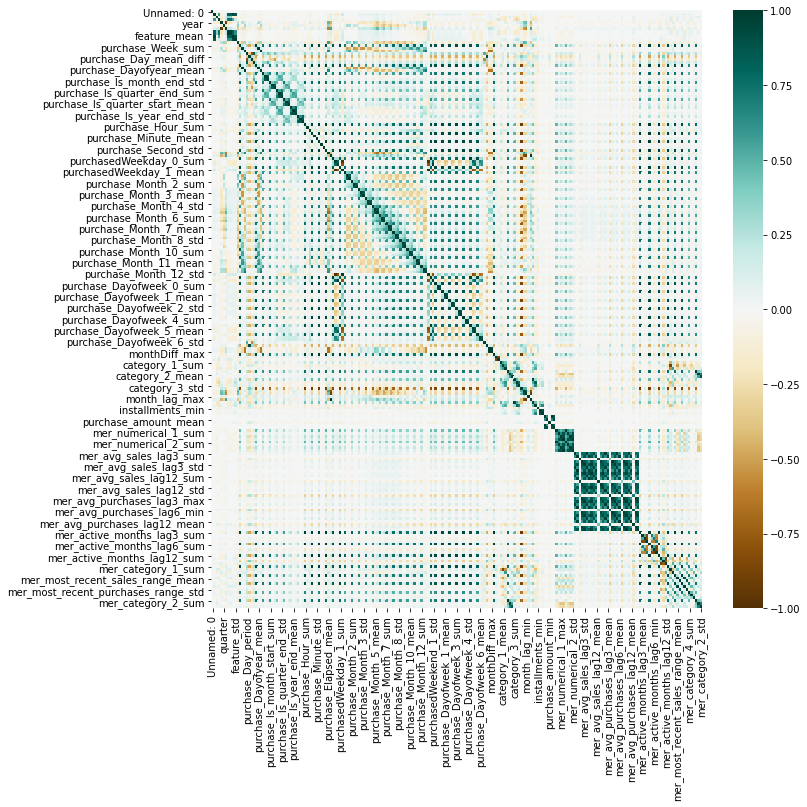

In [ ]:
corr = temp.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corr, vmin=-1, vmax=1, cmap='BrBG')

In [ ]:
# lets find the correlated features 

def correlation(df, theta):
    """
        Finds the correlated features
        ---------------------------------------------------------
        Args:
            df:- The dataframe on which we need to perform correlation analysis
            theta:-  The threshold of the correlation 
        ---------------------------------------------------------
        Returns:
                The correlated values  
        ---------------------------------------------------------
        Author:- Tarini Tanaya Mohapatra 
        
    """
    col_corr = set() #so no other duplicate values 
    corr_matrix = df.corr()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > theta:
                colName = corr_matrix.columns[i]
                col_corr.add(colName)
    return col_corr

In [ ]:
corr_features = correlation(temp, 0.85)
len(set(corr_features))

100

In [ ]:
corrmat = temp.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending = False)
corrmat = corrmat[corrmat >= 0.85]
corrmat = corrmat[corrmat<1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,feature_sum,feature_mean,1.000000
1,feature_mean,feature_sum,1.000000
2,purchasedWeekday_0_mean,purchasedWeekend_0_mean,0.999999
3,purchasedWeekday_0_mean,purchasedWeekday_1_mean,0.999999
4,purchasedWeekday_1_mean,purchasedWeekday_0_mean,0.999999


In [ ]:
corrmat

,feature1,feature2,corr
0,feature_sum,feature_mean,1.000000
1,feature_mean,feature_sum,1.000000
2,purchasedWeekday_0_mean,purchasedWeekend_0_mean,0.999999
3,purchasedWeekday_0_mean,purchasedWeekday_1_mean,0.999999
4,purchasedWeekday_1_mean,purchasedWeekday_0_mean,0.999999
...,...,...,...
787,mer_avg_purchases_lag3_std,mer_avg_purchases_lag12_mean,0.851570
788,purchase_Dayofweek_0_sum,month_lag_sum,0.851508
789,month_lag_sum,purchase_Dayofweek_0_sum,0.851508
790,month_lag_sum,purchase_Week_sum,0.850899


In [ ]:
#find the groups of correlated features 
grouped_feature_ls = []
correlated_groups = []


for feature in corrmat["feature1"].unique():
    if feature not in grouped_feature_ls:
        
        # find all correlated features to a single feature 
        correlated_block = corrmat[corrmat['feature1'] == feature]
        grouped_feeature_ls = grouped_feature_ls + list(
        correlated_block['feature2'].unique()) + [feature]
        
        #append the block of features to the list 
        correlated_groups.append(correlated_block)
        
print('Found {} correlated groups'.format(len(correlated_groups)))
print('Out of {} total features '.format(temp.shape[1]))


Found 155 correlated groups
Out of 211 total features 


In [ ]:
i = 0
for group in correlated_groups:
    i += 1
    print("The group ", i)
    print(group)
    print()

The group  1
      feature1      feature2  corr
0  feature_sum  feature_mean   1.0

The group  2
       feature1     feature2  corr
1  feature_mean  feature_sum   1.0

The group  3
                  feature1                 feature2      corr
2  purchasedWeekday_0_mean  purchasedWeekend_0_mean  0.999999
3  purchasedWeekday_0_mean  purchasedWeekday_1_mean  0.999999

The group  4
                  feature1                 feature2      corr
4  purchasedWeekday_1_mean  purchasedWeekday_0_mean  0.999999

The group  5
                  feature1                 feature2      corr
5  purchasedWeekend_0_mean  purchasedWeekday_0_mean  0.999999

The group  6
                       feature1                             feature2      corr
6    mer_active_months_lag3_sum           mer_active_months_lag6_sum  0.999998
21   mer_active_months_lag3_sum          mer_active_months_lag12_sum  0.999768
33   mer_active_months_lag3_sum                 purchase_Elapsed_sum  0.998470
55   mer_active_months_lag3

In [ ]:
#make y_train 
y_train = train.target
y_train

0        -0.820312
1         0.392822
2         0.687988
3         0.142456
4        -0.159790
            ...   
201912   -2.740234
201913    0.312988
201914    0.093506
201915   -4.675781
201916   -1.859375
Name: target, Length: 201917, dtype: float16

In [ ]:

def deleteColumns(i):
    """
        To remove correlated features and keep the highest important feature of the group
        We use xgbregressor 
        ----------------------------------------------
        Args:
            i:-  Group no
        -----------------------------------------------
        Returns:
            none
        ------------------------------------------------
        Author: Tarini Tanaya Mohapatra 
    
    """
    print(correlated_groups[i].feature1.value_counts().index.values)
    features = list(correlated_groups[i]['feature2'].unique()) + correlated_groups[i].feature1.value_counts().index.values.tolist()
    columns_removal = list(correlated_groups[i]['feature2'].unique()) + correlated_groups[i].feature1.value_counts().index.values.tolist()
    print("The features are ",features)
    rf = xgb.XGBRegressor(objective= 'reg:squarederror')
    rf.fit(train[features], y_train)
    importance = pd.concat(
                        [pd.Series(features),
                        pd.Series(rf.feature_importances_)], axis = 1)
    
    importance.columns = ['feature1', 'importance']
    importance.sort_values(by = 'importance', ascending = False, inplace = True)
    importance.reset_index(inplace = True,drop=True)
    
    columns_removal.remove(importance.feature1[0])
    print("The important feature is ",importance.feature1[0])
    print("The columns to remove ")
    print(columns_removal)
    for col in columnsToTake:
        if col in columns_removal:
            columnsToTake.remove(col)

    print(len(columnsToTake))


In [ ]:
# for 155 groups
for i in range(154):
    print("Group ",i)
    deleteColumns(i)

Group  0
['feature_sum']
The features are  ['feature_mean', 'feature_sum']
The important feature is  feature_mean
The columns to remove 
['feature_sum']
210
Group  1
['feature_mean']
The features are  ['feature_sum', 'feature_mean']
The important feature is  feature_sum
The columns to remove 
['feature_mean']
209
Group  2
['purchasedWeekday_0_mean']
The features are  ['purchasedWeekend_0_mean', 'purchasedWeekday_1_mean', 'purchasedWeekday_0_mean']
The important feature is  purchasedWeekday_0_mean
The columns to remove 
['purchasedWeekend_0_mean', 'purchasedWeekday_1_mean']
207
Group  3
['purchasedWeekday_1_mean']
The features are  ['purchasedWeekday_0_mean', 'purchasedWeekday_1_mean']
The important feature is  purchasedWeekday_1_mean
The columns to remove 
['purchasedWeekday_0_mean']
206
Group  4
['purchasedWeekend_0_mean']
The features are  ['purchasedWeekday_0_mean', 'purchasedWeekend_0_mean']
The important feature is  purchasedWeekend_0_mean
The columns to remove 
['purchasedWeekday

In [ ]:
#lets save the columns to take in a pickle file 
pickle.dump(columnsToTake,open('columnsToTake.pkl','wb'))
columnsToTake = pickle.load(open("columnsToTake.pkl", 'rb')) 

In [ ]:
train

,Unnamed: 0,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,quarter,elapsed_time,feature_sum,feature_mean,feature_max,feature_min,feature_std,purchase_Year_mode,purchase_Week_sum,purchase_Week_mean,purchase_Week_std,purchase_Day_period,purchase_Day_mean_diff,purchase_Day_min,purchase_Day_max,purchase_Dayofyear_sum,purchase_Dayofyear_mean,purchase_Dayofyear_std,purchase_Is_month_end_sum,purchase_Is_month_end_mean,purchase_Is_month_end_std,purchase_Is_month_start_sum,purchase_Is_month_start_mean,purchase_Is_month_start_std,purchase_Is_quarter_end_sum,purchase_Is_quarter_end_mean,purchase_Is_quarter_end_std,purchase_Is_quarter_start_sum,purchase_Is_quarter_start_mean,purchase_Is_quarter_start_std,purchase_Is_year_end_sum,purchase_Is_year_end_mean,...,mer_avg_purchases_lag3_std,mer_avg_purchases_lag6_sum,mer_avg_purchases_lag6_mean,mer_avg_purchases_lag6_min,mer_avg_purchases_lag6_max,mer_avg_purchases_lag6_std,mer_avg_purchases_lag12_sum,mer_avg_purchases_lag12_mean,mer_avg_purchases_lag12_min,mer_avg_purchases_lag12_max,mer_avg_purchases_lag12_std,mer_active_months_lag3_sum,mer_active_months_lag3_mean,mer_active_months_lag3_min,mer_active_months_lag3_std,mer_active_months_lag6_sum,mer_active_months_lag6_mean,mer_active_months_lag6_min,mer_active_months_lag6_std,mer_active_months_lag12_sum,mer_active_months_lag12_mean,mer_active_months_lag12_min,mer_active_months_lag12_max,mer_active_months_lag12_std,mer_category_1_sum,mer_category_1_mean,mer_category_1_std,mer_most_recent_sales_range_sum,mer_most_recent_sales_range_mean,mer_most_recent_sales_range_std,mer_most_recent_purchases_range_sum,mer_most_recent_purchases_range_mean,mer_most_recent_purchases_range_std,mer_category_4_sum,mer_category_4_mean,mer_category_4_std,mer_category_2_sum,mer_category_2_mean,mer_category_2_std,outliers
0,0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,2017,2,1363,8,2.666016,5,1,2.082031,2017,8905,31.468750,15.554688,30,0.106384,1,31,61760,218.250,109.1875,9,0.031799,0.175781,7,0.024734,0.155640,5,0.017670,0.131958,3,0.010597,0.102600,1,0.003534,...,2.099609,5482.195801,19.437500,0.321045,504.250000,93.312500,6044.127441,21.437500,0.252930,554.500000,102.812500,846.0,3.000000,3.0,0.000000,1691.0,5.996094,5.0,0.059540,3348.0,11.875000,5.0,12.0,0.794434,258.0,0.915039,0.279541,469.0,1.663086,1.278320,410.0,1.454102,1.288086,16.0,0.056732,0.231812,294.0,1.042969,0.411133,0
1,1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,2017,1,1514,5,1.666992,4,0,2.082031,2017,8881,24.953125,16.703125,30,0.084534,1,31,61516,172.750,117.1875,12,0.033722,0.180786,15,0.042145,0.201172,6,0.016861,0.128906,6,0.016861,0.128906,3,0.008430,...,1.900391,1546.058960,4.167969,0.307861,504.250000,36.937500,1679.206055,4.527344,0.208984,554.500000,40.625000,1113.0,3.000000,3.0,0.000000,2226.0,6.000000,6.0,0.000000,4400.0,11.859375,7.0,12.0,0.788574,309.0,0.833008,0.373535,403.0,1.085938,1.363281,397.0,1.070312,1.364258,29.0,0.078186,0.268799,371.0,1.000000,0.000000,0
2,2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988,2016,3,1667,4,1.333008,2,0,1.154297,2017,807,18.343750,13.726562,28,0.651367,2,30,5572,126.625,96.5000,1,0.022720,0.150757,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,...,1.741211,61.962299,1.376953,0.871094,15.859375,2.208984,62.840199,1.396484,0.752441,16.218750,2.261719,135.0,3.000000,3.0,0.000000,270.0,6.000000,6.0,0.000000,533.0,11.843750,7.0,12.0,0.796387,43.0,0.955566,0.208374,18.0,0.399902,0.962891,18.0,0.399902,1.008789,3.0,0.066650,0.252197,205.0,4.554688,1.271484,0
3,3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456,2017,3,1271,7,2.333984,4,0,2.082031,2017,2562,30.500000,17.140625,29,0.349365,2,31,17723,211.000,120.3750,3,0.035706,0.186646,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,...,3.421875,230.861694,2.404297,0.426270,15.859375,4.355469,234.079895,2.437500,0.436035,16.218750,4.460938,288.0,3.000000,3.0,0.000000,576.0,6.000000,6.0,0.000000,1094.0,11.398438,7.0,12.0,1.539062,65.0,0.677246,0.469971,

## Model Building 

In [7]:
#load train
train = reduce_mem_usage(pd.read_csv('FINAL_TRAIN_M.csv'))
test = reduce_mem_usage(pd.read_csv('FINAL_TEST_M.csv'))

Mem. usage decreased to 94.74 Mb (72.3% reduction)
Mem. usage decreased to 58.59 Mb (71.9% reduction)


In [8]:
columnsToTake = pickle.load(open("columnsToTake.pkl", 'rb')) 

In [9]:
t_df = train[columnsToTake]

In [10]:
tt_df = test[columnsToTake]

In [14]:
target = train['target']

In [17]:
# set the parameters 

lgb_params = {'num_leaves': 50, # No of leaves 
         'min_data_in_leaf': 30, 
         # objective 
         'objective':'regression',
         'max_depth': -1, 
         'learning_rate': 0.005,  # learning rate 
          "boosting": "gbdt", # boosting type 
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}
         
# initilize the folds 
FOLDs = KFold(n_splits=5, shuffle=True, random_state=1234)

# validation score 
oof_lgb = np.zeros(len(t_df))
# will save the predictions here 
predictions_lgb = np.zeros(len(tt_df))

# to see the important features 
features_lgb = list(t_df.columns)

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    # train and val division 
    trn_data = lgb.Dataset(t_df.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(t_df.iloc[val_idx], label=target.iloc[val_idx])

    # printing 
    print("LGB " + str(fold_) + "-" * 50)
    num_round = 2000
    # training 
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 2000)
    oof_lgb[val_idx] = clf.predict(t_df.iloc[val_idx], num_iteration=clf.best_iteration)
    # predictions 
    predictions_lgb += clf.predict(tt_df, num_iteration=clf.best_iteration) / FOLDs.n_splits
    


del trn_data
del val_data

print(np.sqrt(mean_squared_error(oof_lgb, target)))


LGB 0--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.65921	valid_1's rmse: 3.69279
[400]	training's rmse: 3.56042	valid_1's rmse: 3.67615
[600]	training's rmse: 3.49092	valid_1's rmse: 3.66968
[800]	training's rmse: 3.44087	valid_1's rmse: 3.66608
[1000]	training's rmse: 3.40163	valid_1's rmse: 3.66431
[1200]	training's rmse: 3.36675	valid_1's rmse: 3.66296
[1400]	training's rmse: 3.33461	valid_1's rmse: 3.66254
[1600]	training's rmse: 3.30592	valid_1's rmse: 3.66215
[1800]	training's rmse: 3.27864	valid_1's rmse: 3.66172
[2000]	training's rmse: 3.25248	valid_1's rmse: 3.6617
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.25248	valid_1's rmse: 3.6617
LGB 1--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.62401	valid_1's rmse: 3.84096
[400]	training's rmse: 3.52604	valid_1's rmse: 

In [18]:
submission = pd.read_csv('sample_submission.csv')
submission 

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0
...,...,...
123618,C_ID_7a239d2eda,0
123619,C_ID_75ace375ae,0
123620,C_ID_21d56d950c,0
123621,C_ID_6c46fc5a9d,0


In [19]:
submission["target"] =  predictions_lgb
submission.to_csv("submission_lgb.csv", index=False)

In [20]:
submission

,card_id,target
0,C_ID_0ab67a22ab,-4.069271
1,C_ID_130fd0cbdd,-0.059721
2,C_ID_b709037bc5,-0.108510
3,C_ID_d27d835a9f,-0.232105
4,C_ID_2b5e3df5c2,-0.377504
...,...,...
123618,C_ID_7a239d2eda,0.803551
123619,C_ID_75ace375ae,-0.138087
123620,C_ID_21d56d950c,0.843735
123621,C_ID_6c46fc5a9d,-2.395465


In [21]:
#lets save the columns to take in a pickle file 
pickle.dump(clf,open('lgb.pkl','wb'))
clf = pickle.load(open("lgb.pkl", 'rb')) 

In [22]:
# set the parameters 
xgb_params = {'eta': 0.001,
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8, 
              'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'silent': True}

# initilize the folds 
FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_xgb = np.zeros(len(t_df))
predictions_xgb = np.zeros(len(tt_df))

#create folds 
for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(t_df)):
    # Create the train data  
    trn_data = xgb.DMatrix(data=t_df.iloc[trn_idx], label=target.iloc[trn_idx])
    # Create the val data 
    val_data = xgb.DMatrix(data=t_df.iloc[val_idx], label=target.iloc[val_idx])
    # specify validations set to watch performance
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    # print important information 
    print("xgb " + str(fold_) + "-" * 50)
    # The number of rounds for boosting 
    num_round = 2000
    # Train the model 
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=100, verbose_eval=200)
    # Find the validation 
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(t_df.iloc[val_idx]), ntree_limit=xgb_model.best_ntree_limit+50)
    # save the predictions 
    predictions_xgb += xgb_model.predict(xgb.DMatrix(tt_df), ntree_limit=xgb_model.best_ntree_limit+50) / FOLDs.n_splits

mean_squared_error(oof_xgb, target, squared=False)
del trn_data
del val_data
del watchlist
gc.collect()

xgb 0--------------------------------------------------
[0]	train-rmse:3.93274	valid-rmse:4.02922
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:3.84107	valid-rmse:3.95552
[400]	train-rmse:3.77195	valid-rmse:3.90369
[600]	train-rmse:3.71815	valid-rmse:3.86718
[800]	train-rmse:3.67534	valid-rmse:3.84125
[1000]	train-rmse:3.64053	valid-rmse:3.82285
[1200]	train-rmse:3.61202	valid-rmse:3.80949
[1400]	train-rmse:3.58753	valid-rmse:3.79961
[1600]	train-rmse:3.56635	valid-rmse:3.7925
[1800]	train-rmse:3.54784	valid-rmse:3.78714
[1999]	train-rmse:3.53148	valid-rmse:3.78308
xgb 1--------------------------------------------------
[0]	train-rmse:3.96747	valid-rmse:3.89051
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:3.87264	valid-rmse:3.82097
[400]	train-rmse:3.8008

613

In [23]:
submission = pd.read_csv('sample_submission.csv')
submission 

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0
...,...,...
123618,C_ID_7a239d2eda,0
123619,C_ID_75ace375ae,0
123620,C_ID_21d56d950c,0
123621,C_ID_6c46fc5a9d,0


In [24]:
submission["target"] = predictions_xgb
submission.to_csv("submission_xgboost.csv", index=False)

In [25]:
submission

,card_id,target
0,C_ID_0ab67a22ab,-3.689599
1,C_ID_130fd0cbdd,-0.092184
2,C_ID_b709037bc5,-0.208009
3,C_ID_d27d835a9f,-0.545438
4,C_ID_2b5e3df5c2,-0.379707
...,...,...
123618,C_ID_7a239d2eda,0.717616
123619,C_ID_75ace375ae,-0.177311
123620,C_ID_21d56d950c,0.756841
123621,C_ID_6c46fc5a9d,-1.782976


In [26]:
#lets save the columns to take in a pickle file 
pickle.dump(xgb_model,open('xgb.pkl','wb'))
xgb_model = pickle.load(open("xgb.pkl", 'rb')) 